#Initialization

In [ ]:
if (!require("igraph")) install.packages("igraph")
library ("igraph")
if (!require("clevr")) install.packages("clevr")
library ("clevr")

Loading required package: igraph

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘igraph’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: clevr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘clevr’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘BH’




In [ ]:
unzip('finance_data.zip')

#Daily

In [ ]:
#Question 2
tickers_sectors <- read.csv(file = 'finance_data/Name_sector.csv',header=TRUE,stringsAsFactors=FALSE)
filenames = paste("finance_data/data", list.files("finance_data/data", pattern="*.csv"), sep="/")

length_data<-c()
i<-1
log_norm_mat = matrix(0,length(filenames)-11,764) #omit files with NaN data
for(j in c(1:length(filenames))){
    df = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    #print(length(df))
    length_data[j] = dim(df)[1]
    #print(length_data)
    if(length_data[j]==765){
        p = df[,5] 
        #print(df[,5])
        q = c()
        r = c()
        for(k in c(2:length(p))){
            q[k-1] = (p[k]-p[k-1])/p[k-1]
        }
        r = log(1+q)
        #print(length(r))
        log_norm_mat[i,] = r
        i = i+1
    }
}

In [ ]:
#correlation 
cal_cor<-function(comp_date){
  #write code  
  length_data<-c()
  i<-1
  log_norm_mat = matrix(0,length(comp_date),764) #omit files with NaN data
  for(j in c(1:length(comp_date))){
    
    length_data[j] = dim(m)[1]
    print(length_data)
    if(length_data[j]==765){
        p = m[,5] 
        print(p)
        q = c()
        r = c()
        for(k in c(2:length(p))){
            q[k-1] = (p[k]-p[k-1])/p[k-1]
        }
        r = log(1+q)
        print(length(r))
        log_norm_mat[i,] = r
        i = i+1
    }
}

for(i in c(1:(dim(log_norm_mat)[1]-1))){
    for(j in c((i+1):dim(log_norm_mat)[1])){
      ri <- mean(log_norm_mat[i,]) 
      rj <- mean(log_norm_mat[j,])
      ri2 <- log_norm_mat[i,]^2
      rj2 <- log_norm_mat[j,]^2
      val <- ((mean(log_norm_mat[i,],log_norm_mat[j,]))-(ri*rj))/(sqrt((mean(ri2)-(ri^2))(mean(rj2)-(rj^2))))

     
    }
  }
return(val)
    }

In [ ]:
#temp <- cal_cor(m)

In [ ]:
#print(cal_cor())

In [ ]:
get_edges<- function(edge_weight_file,log_norm_mat,tickers_sectors){
  cat("Source","\t","Sink","\t","Weight",file=edge_weight_file)
  for(i in c(1:(dim(log_norm_mat)[1]-1))){
    for(j in c((i+1):dim(log_norm_mat)[1])){
      ri <- mean(log_norm_mat[i,]) 
      rj <- mean(log_norm_mat[j,])
      ri2 <- log_norm_mat[i,]^2
      rj2 <- log_norm_mat[j,]^2
      rhoij <- ((mean(log_norm_mat[i,]*log_norm_mat[j,]))-(ri*rj))/(sqrt((mean(ri2)-(ri^2))*(mean(rj2)-(rj^2))))
      wij <- sqrt(2*(1-rhoij))
      cat('\n',tickers_sectors[i,1],'\t',tickers_sectors[j,1],'\t',wij,file=edge_weight_file)
    }
  }
}

In [ ]:
tickers_sectors=tickers_sectors[-which(length_data!=765),]
edge_weight_file <- file("finance_data/edge_weights.txt", "w")
get_edges(edge_weight_file,log_norm_mat,tickers_sectors)
close(edge_weight_file)

edge_list= read.delim("finance_data/edge_weights.txt",header=TRUE)
correlation_graph = graph.data.frame(edge_list, directed = FALSE)
E(correlation_graph)$weight = edge_list[,"Weight"]

png 
  2

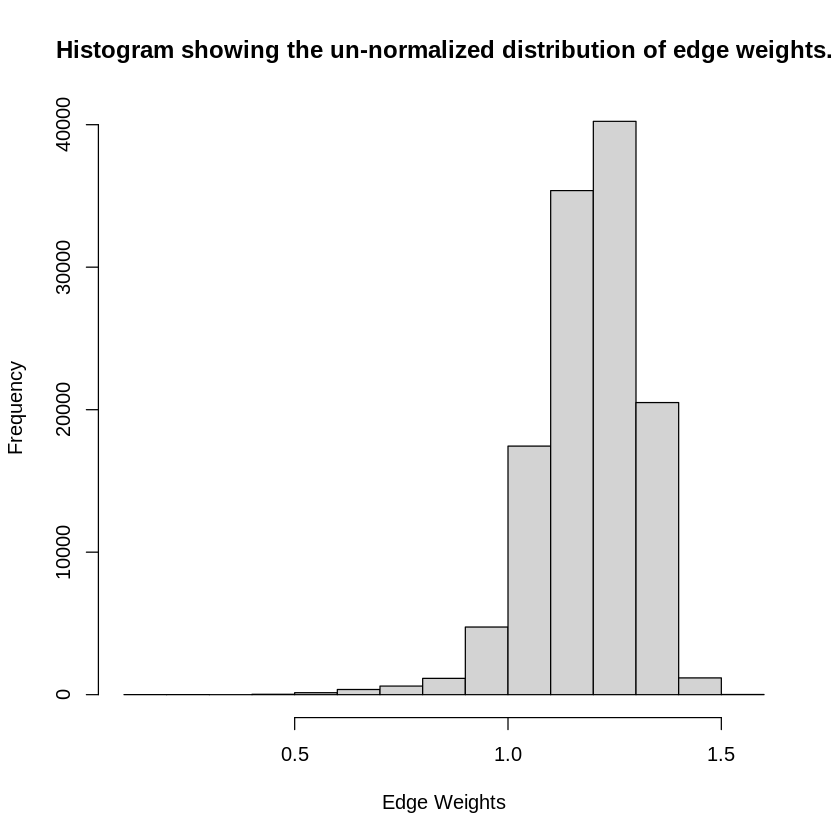

In [ ]:
hist(edge_list[,"Weight"],main="Histogram showing the un-normalized distribution of edge weights.",xlab="Edge Weights",ylab="Frequency")
dev.copy2eps(file='Q2.eps')

png 
  2

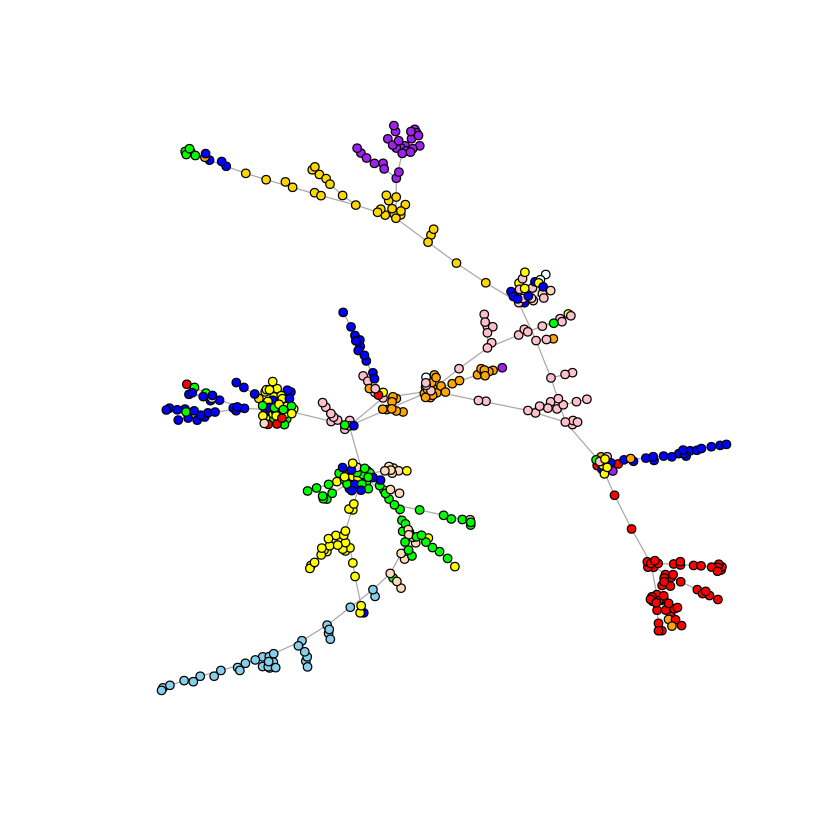

In [ ]:
#Question 3
mst <- mst(correlation_graph,algorithm="prim")
sectors = unique(tickers_sectors[,2])

colors <- c()
  for(v in c(1:vcount(correlation_graph))){
    cur_sector <- tickers_sectors[v,2]
    i <- which(sectors==cur_sector)
    colors[v] <- switch(i,"red","green","blue","yellow","orange","purple","pink","gold","peachpuff","skyblue","azure")
}

plot(mst,vertex.size=3, vertex.label=NA, vertex.color=colors)
dev.copy2eps(file='Q3.eps')


In [ ]:
#OUR Q4
wt<-cluster_walktrap(mst)

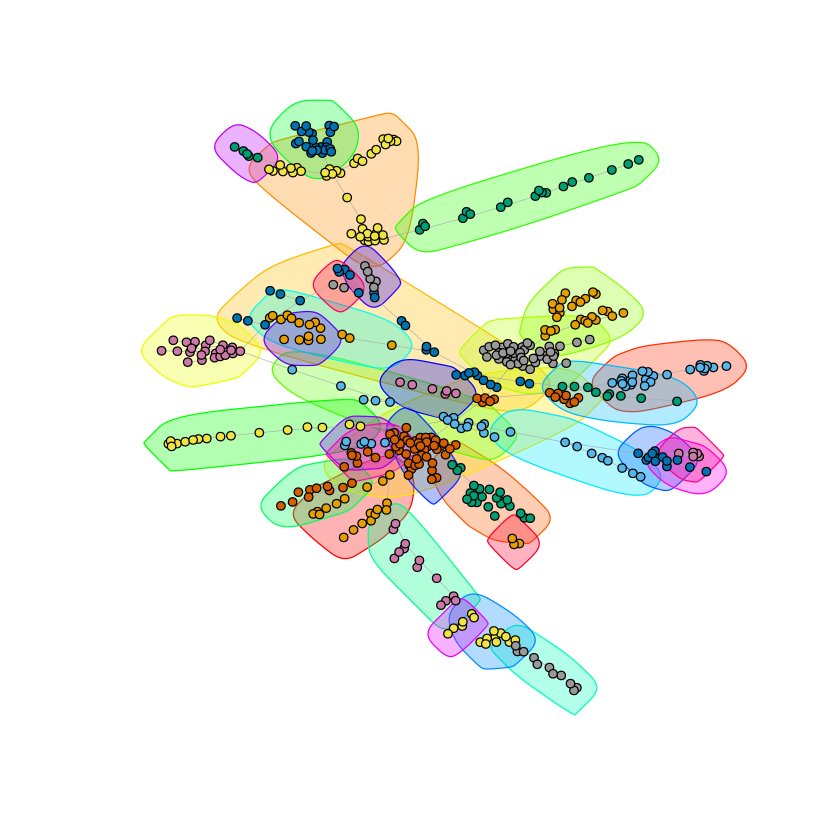

In [ ]:
plot(mst, mark.groups = wt, edge.width = 0.5, vertex.size = 3, vertex.color = wt$membership, vertex.label = "")

In [ ]:
path = "finance_data/data/"
out.file<-""
file.names <- dir(path, pattern =".csv")
m <- matrix(, nrow = 0, ncol = 765)
sectors.table <- read.table("finance_data/Name_sector.csv", header=TRUE, sep=",", stringsAsFactors=TRUE)
sectors = c()
sectors.names <- c()
for(i in 1:length(file.names)){
    file <- read.table(paste("finance_data/data/",file.names[i],sep = ""), header=TRUE, sep=",", stringsAsFactors=FALSE)
    if(length(file$Close)==765){
        m <- rbind(m, matrix(file$Close, nrow=1, ncol=765))
        mystr <- substr(file.names[i], 1, nchar(file.names[i])-4)
        sector <- sectors.table$Sector[which(sectors.table$Symbol == mystr)]
#         print(sector)
#        sectors = c(sectors, as.factor(sector))
        sectors.names = c(sectors.names, toString(sector))
    }
}
com_num = length(sectors.names)
data_num = ncol(m)
sector.set<-as.factor(sectors.names)
sectors.index<-as.numeric(sector.set)
num_sector <- length(unique(sectors.index))
print(length(m))
table(sector.set)

[1] 377910


sector.set
    Consumer Discretionary           Consumer Staples 
                        84                         36 
                    Energy                 Financials 
                        34                         63 
               Health Care                Industrials 
                        60                         64 
    Information Technology                  Materials 
                        66                         24 
               Real Estate Telecommunication Services 
                        31                          4 
                 Utilities 
                        28 

In [ ]:
# Find the value of S_i for all i: The number of memebver in each community. 
S_i = c()
print("Number of nodes belonging each Sector")
for(i in c(1:length(sectors))){
    S_i[i] = length(which(tickers_sectors[,2]==sectors[i]))
    print(sprintf("%s: %s", sectors[i], S_i[i]))
}

# find alpha for 
p_method_1 = c()
p_method_2 = c()
for(v in c(1:vcount(mst))){
    neighbors_v = neighbors(mst,v)
    N_i = length(neighbors_v)
    Q_i=0
    for(i in neighbors_v){
        if(tickers_sectors[i,2]==tickers_sectors[v,2])
            Q_i=Q_i+1
    }
    p_method_1[v] = Q_i/N_i
    p_method_2[v] = S_i[which(sectors==tickers_sectors[v,2])]/vcount(mst)
}


[1] "Number of nodes belonging each Sector"
character(0)
character(0)


In [ ]:
alpha_1 = sum(p_method_1)/vcount(mst)
print(sprintf("Alpha value for method 1 is: %s",alpha_1))
alpha_2 = sum(p_method_2)/vcount(mst)
print(sprintf("Alpha value for method 2 is: %s",alpha_2))

[1] "Alpha value for method 1 is: 0.828930077530676"
[1] "Alpha value for method 2 is: 0.1141"


In [ ]:
print(length(sectors.index))
print(length(wt$membership))

[1] 494
[1] 494


In [ ]:
#homogeneity and completeness
#figure out true and pred
true<- c(sectors.index)
pred <- c(wt$membership)
print("The homogenety for Daily data:\n")
homogeneity(true, pred)
print("The completness for Daily data:\n")
completeness(true,pred)

[1] "The homogenety for Daily data:\n"


[1] 0.6826446

[1] "The completness for Daily data:\n"


[1] 0.4792845

#Weekly

In [ ]:
company_ticker_list_week = read.csv("finance_data/Name_sector.csv",header=TRUE,stringsAsFactors=FALSE)
filenames_week <- list.files("finance_data/data/", pattern="*.csv")
filenames_week = paste("finance_data/data", filenames_week, sep="/")
print(sprintf("Number of companies in the ticker list is %s",length(filenames_week)))
comp_del_week=0
for(j in c(1:length(filenames_week))){
    comp_data_week = read.csv(filenames_week[j],header=TRUE, stringsAsFactors=FALSE)
    comp_data_week["Day"]=weekdays(as.Date(comp_data_week[,1])) 
    comp_data_week =subset(comp_data_week, Day=='Monday')

    mystr <- substr(file.names[i], 1, nchar(file.names[j])-4)
    sector <- sectors.table$Sector[which(sectors.table$Symbol == mystr)]
    
    
    if(dim(comp_data_week)[1]!=143){
#         print(dim(df)[1])
        comp_del_week=comp_del_week+1
    }
}
print(sprintf("Number of companies in the ticker list with missing data for Mondays: %s",comp_del_week))

[1] "Number of companies in the ticker list is 505"
[1] "Number of companies in the ticker list with missing data for Mondays: 13"


In [ ]:
i=1 # i is the ith stock 
log_norm_return_week = matrix(0,length(filenames_week)-comp_del_week,142)
num_data_points_week=c()
for(j in c(1:length(filenames_week))){
    comp_data_week = read.csv(filenames_week[j],header=TRUE, stringsAsFactors=FALSE)
    comp_data_week["Day"]=weekdays(as.Date(comp_data_week[,1])) 
    comp_data_week =subset(comp_data_week, Day=='Monday')
 
    num_data_points_week[j] = dim(comp_data_week)[1]
    if(num_data_points_week[j]==143){
        p_week = comp_data_week[,5] # list of closing price
        q_week = c() # list of return of stock over a period of [t − 1, t]q[1] = p[1]
        r_week = c()
        for(t in c(2:length(p_week))){
            q_week[t-1] = (p_week[t]-p_week[t-1])/p_week[t-1]
        }
        r_week = log(1+q_week)
        log_norm_return_week[i,] = r_week
        i = i+1
    }
}


In [ ]:
comp_ignore_week=which(num_data_points_week!=143)
company_ticker_list_week=company_ticker_list_week[-comp_ignore_week,]


wt_file_week = file("finance_data/edge_weights_week.txt", "w")
get_edges(wt_file_week,log_norm_return_week,company_ticker_list_week)
close(wt_file_week)

,Source,Sink,Weight
,<chr>,<chr>,<dbl>
1,A,AAL,1.199583
2,A,AAP,1.260472
3,A,AAPL,1.426122
4,A,ABBV,1.110045
5,A,ABC,1.230741
6,A,ABT,1.005328
7,A,ACN,1.045794
8,A,ADBE,1.051711
9,A,ADI,1.122624


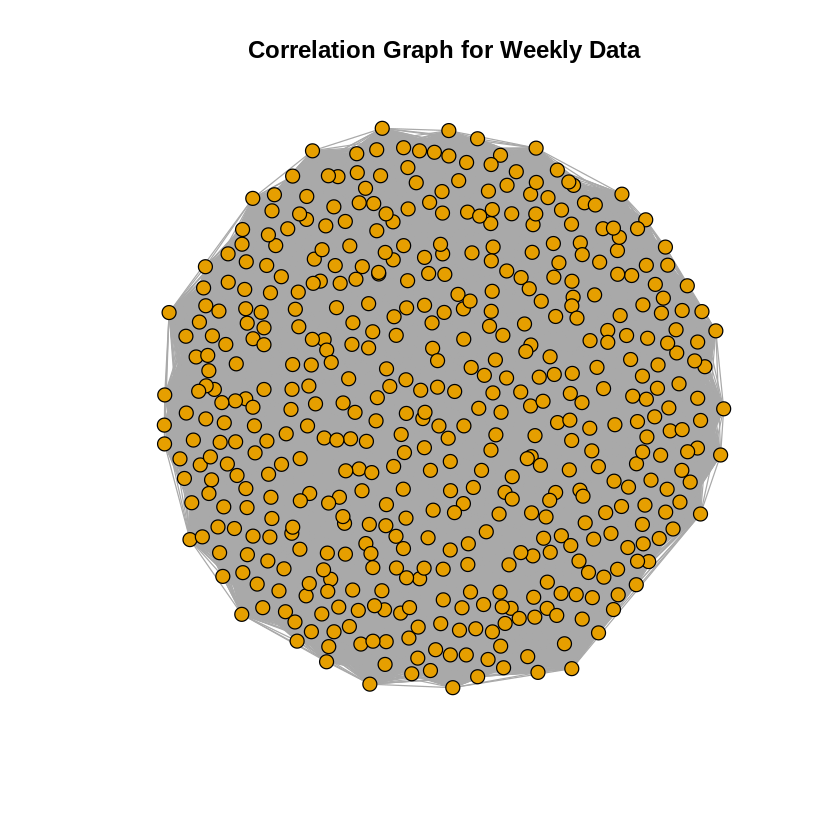

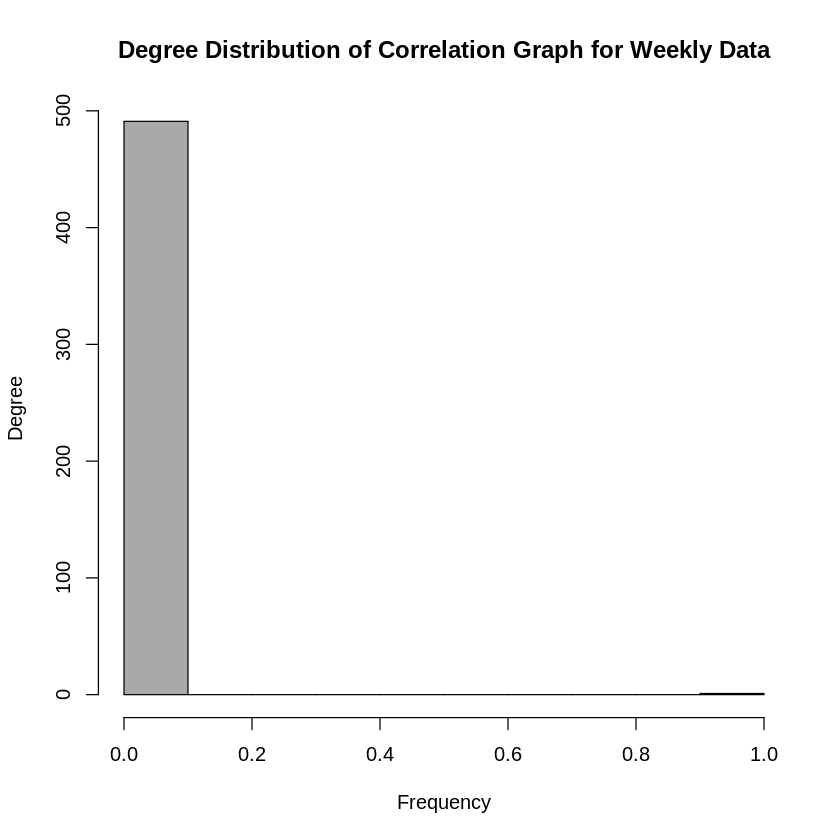

[1] "Number of unique sectors: 11"


[1] "Health Care"                "Industrials"               
 [3] "Consumer Discretionary"     "Information Technology"    
 [5] "Consumer Staples"           "Utilities"                 
 [7] "Financials"                 "Real Estate"               
 [9] "Materials"                  "Energy"                    
[11] "Telecommunication Services"

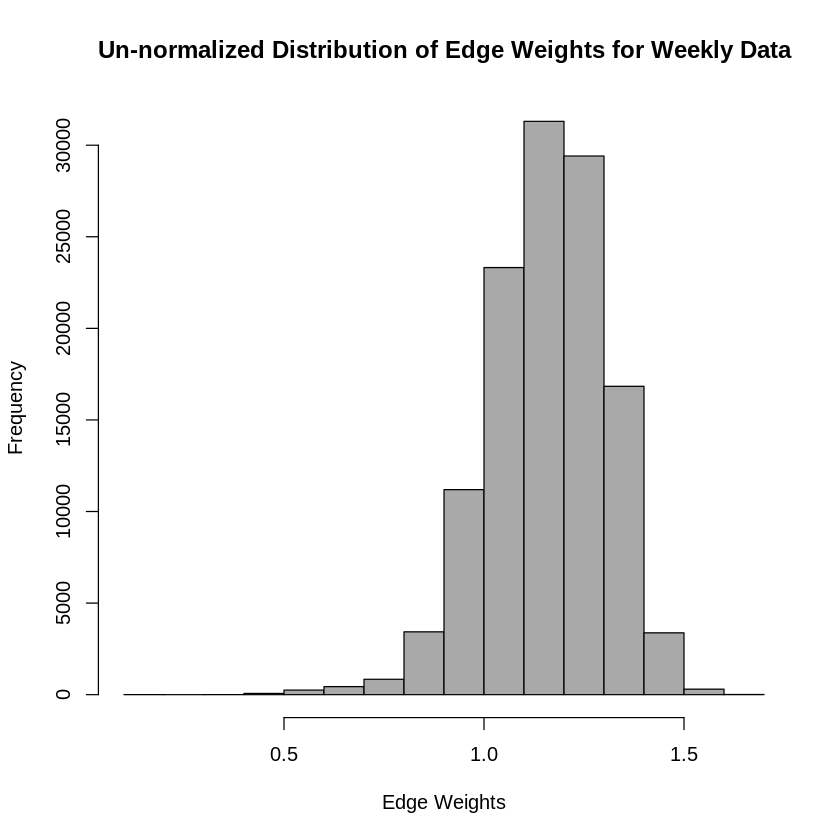

In [ ]:
edge_list_week= read.delim("finance_data/edge_weights_week.txt",header=TRUE)
corr_graph_week = graph.data.frame(edge_list_week, directed = FALSE)
E(corr_graph_week)$weight = edge_list_week[,"Weight"]


# step 4: plot histogram and other data analyis outputs. 
head(edge_list_week,n = 15L)
plot(corr_graph_week, vertex.label="", vertex.size=5,main="Correlation Graph for Weekly Data")
hist(degree.distribution(corr_graph_week),col="darkgrey",main="Degree Distribution of Correlation Graph for Weekly Data", ylab="Degree",xlab="Frequency")
hist(edge_list_week[,"Weight"],col="darkgrey",main="Un-normalized Distribution of Edge Weights for Weekly Data",xlab="Edge Weights",ylab="Frequency")


# Find the number of sectors. 

comp_sectors_week = unique(company_ticker_list_week[,2])
#comp_sectors_week.index<-as.numeric(comp_sectors_week.set)
print(sprintf("Number of unique sectors: %s" , length(comp_sectors_week)))
sprintf(comp_sectors_week)



png 
  2

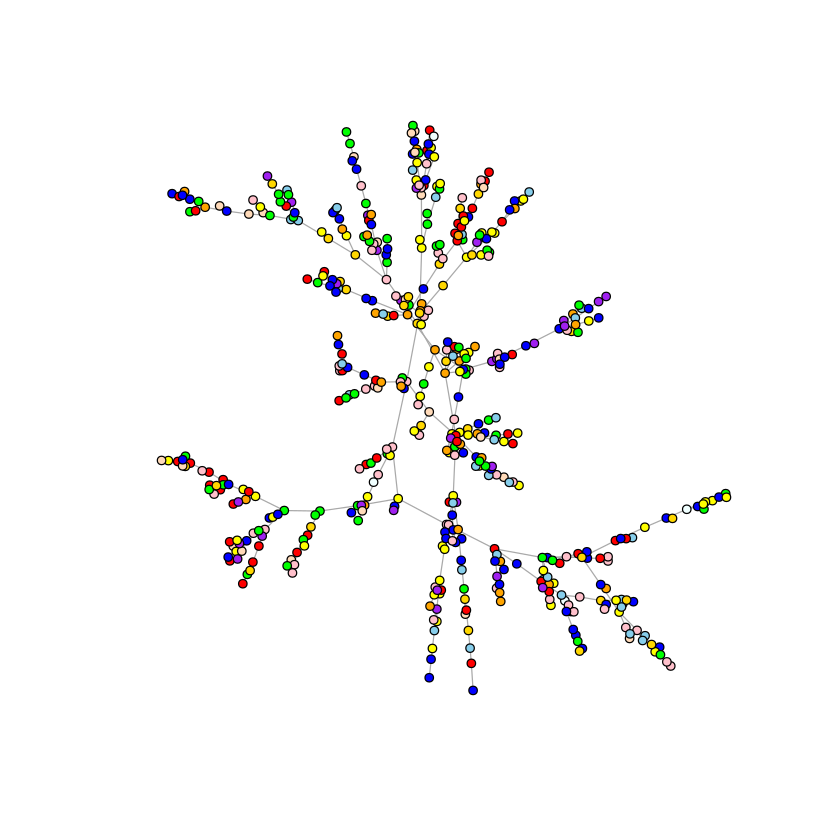

In [ ]:
mst_week <- mst(corr_graph_week,algorithm="prim")
sectors = unique(tickers_sectors[,2])

colors <- c()
  for(v in c(1:vcount(corr_graph_week))){
    cur_sector <- tickers_sectors[v,2]
    i <- which(sectors==cur_sector)
    colors[v] <- switch(i,"red","green","blue","yellow","orange","purple","pink","gold","peachpuff","skyblue","azure")
}

plot(mst_week,vertex.size=3, vertex.label=NA, vertex.color=colors)
dev.copy2eps(file='Q6.eps')


In [ ]:
# Find the value of S_i for all i: The number of memebver in each community. 
S_i = c()
print("Number of nodes belonging each Sector")
for(i in c(1:length(sectors))){
    S_i[i] = length(which(tickers_sectors[,2]==sectors[i]))
    print(sprintf("%s: %s", sectors[i], S_i[i]))
}

# find alpha for 
p_method_1 = c()
p_method_2 = c()
for(v in c(1:vcount(mst_week))){
    neighbors_v = neighbors(mst_week,v)
    N_i = length(neighbors_v)
    Q_i=0
    for(i in neighbors_v){
        if(tickers_sectors[i,2]==tickers_sectors[v,2])
            Q_i=Q_i+1
    }
    p_method_1[v] = Q_i/N_i
    p_method_2[v] = S_i[which(sectors==tickers_sectors[v,2])]/vcount(mst_week)
}


[1] "Number of nodes belonging each Sector"
[1] "Health Care: 60"
[1] "Industrials: 64"
[1] "Consumer Discretionary: 84"
[1] "Information Technology: 66"
[1] "Consumer Staples: 36"
[1] "Utilities: 28"
[1] "Financials: 63"
[1] "Real Estate: 31"
[1] "Materials: 24"
[1] "Energy: 34"
[1] "Telecommunication Services: 4"


In [ ]:
alpha_1 = sum(p_method_1)/vcount(mst_week)
print(sprintf("Alpha value for method 1 is: %s",alpha_1))
alpha_2 = sum(p_method_2)/vcount(mst_week)
print(sprintf("Alpha value for method 2 is: %s",alpha_2))

[1] "Alpha value for method 1 is: 0.73936556329849"
[1] "Alpha value for method 2 is: 0.114610185736004"


In [ ]:
weights_week <- cluster_walktrap(mst_week)

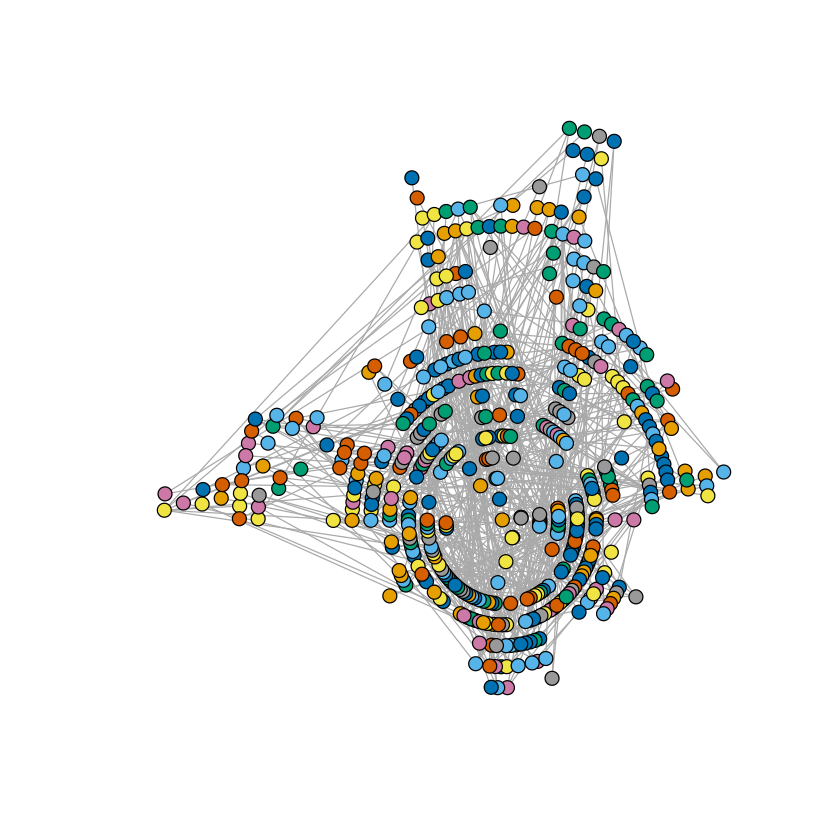

In [ ]:
plot(mst_week,vertex.size=5, vertex.label=NA, vertex.color = weights_week$membership, layout=layout.reingold.tilford(mst,circular=T))

In [ ]:
true<- c(head(sectors.index, - 2))
#true<- c(sectors.index)
pred <- c(weights_week$membership)
print("The homogenety for Daily data:\n")
homogeneity(true, pred)
print("The completness for Daily data:\n")
completeness(true,pred)

[1] "The homogenety for Daily data:\n"


[1] 0.6082186

[1] "The completness for Daily data:\n"


[1] 0.4084197

#Monthly

In [ ]:
company_ticker_list_month = read.csv("finance_data/Name_sector.csv",header=TRUE,stringsAsFactors=FALSE)
filenames_month <- list.files("finance_data/data/", pattern="*.csv")
filenames_month = paste("finance_data/data", filenames_month, sep="/")
print(sprintf("Number of companies in the ticker list is %s",length(filenames_month)))
comp_del_month=0
for(j in c(1:length(filenames_month))){
    comp_data_month = read.csv(filenames_month[j],header=TRUE, stringsAsFactors=FALSE)
    #print(comp_data_month[,1])
    comp_data_month["Date"] = (as.Date(comp_data_month[,1]))

    #print(comp_data_month["Date"][1])
    comp_data_month["Date"]  <-(format(comp_data_month["Date"], format = "%d") )
 #   print(comp_data_month["Date"][1])
    # print(comp_data_month["Date"][1,1,1])
    # print(comp_data_month["Date"][1,1,2])
    # print(comp_data_month["Date"][1,1,3])
    # print(comp_data_month["Date"][1])
    
    comp_data_month["Date"] = as.numeric(unlist(comp_data_month["Date"]))
    # print(comp_data_month["Date"] )
    # print(length(comp_data_month["Date"]))
    for(i in c(1:length(comp_data_month["Date"][1]))){
        #print(length(comp_data_month["Date"][1]))
     
        #print(a1)
        if(is.numeric(comp_data_month["Date"][1,1,i])){
  
          #print(comp_data_month["Date"][1,1,i] )
          
         
        }
        else{
       
          comp_data_month["Date"][1,1,i] = 0
        }
    }
  #  print(comp_data_month["Date"][1])
    #print(substr(comp_data_month["Date"][1],1,1)) 
    #print(comp_data_month[1])
    comp_data_month =subset(comp_data_month, Date==15)
    #print(comp_data_month[1])
    # print(comp_data_month)
    # mystr <- substr(file.names[i], 1, nchar(file.names[j])-4)
    # sector <- sectors.table$Sector[which(sectors.table$Symbol == mystr)]
    
    
    if(dim(comp_data_month)[1]!=25){
        print(dim(df)[1])
        comp_del_month=comp_del_month+1
    }
}
comp_data_month = comp_data_month[,5]
print(sprintf("Number of companies in the ticker list with missing data for 15: %s",comp_del_month))

[1] "Number of companies in the ticker list is 505"
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] 765
[1] "Number of companies in the ticker list with missing data for 15: 13"


In [ ]:
print(comp_data_month)

 [1] 30.46 32.39 33.69 36.27 35.26 41.74 42.94 47.00 46.49 49.27 47.11 45.06
[13] 43.00 46.97 43.38 40.72 48.11 47.22 49.68 52.38 50.72 49.15 52.32 55.15
[25] 54.28


In [ ]:
i=1 # i is the ith stock 
log_norm_return_month = matrix(0,length(filenames_month)-comp_del_month,142)
num_data_points_month = c()
for(j in c(1:length(filenames_month))){
    comp_data_month = read.csv(filenames_month[j],header=TRUE, stringsAsFactors=FALSE)
    comp_data_month["Day"] = weekdays(as.Date(comp_data_month[,1])) 
    comp_data_month = subset(comp_data_month, Day=='Monday')
 
    num_data_points_month[j] = dim(comp_data_month)[1]
    if(num_data_points_month[j]==143){
        p_month = comp_data_month[,5] # list of closing price
        q_month = c() # list of return of stock over a period of [t − 1, t]q[1] = p[1]
        r_month = c()
        for(t in c(2:length(p_month))){
            q_month[t-1] = (p_month[t] - p_month[t-1]) / p_month[t-1]
        }
        r_month = log( 1 + q_month)
        log_norm_return_month[i,] = r_month
        i = i+1
    }
}


In [ ]:
comp_ignore_month =13
company_ticker_list_month = company_ticker_list_month[-comp_ignore_month,]


wt_file_month = file("finance_data/edge_weights_month.txt", "w")
get_edges(wt_file_month,log_norm_return_month,company_ticker_list_month)
close(wt_file_month)

,Source,Sink,Weight
,<chr>,<chr>,<dbl>
1,A,AAL,1.199583
2,A,AAP,1.260472
3,A,AAPL,1.426122
4,A,ABBV,1.110045
5,A,ABC,1.230741
6,A,ABT,1.005328
7,A,ACN,1.045794
8,A,ADBE,1.051711
9,A,ADI,1.122624


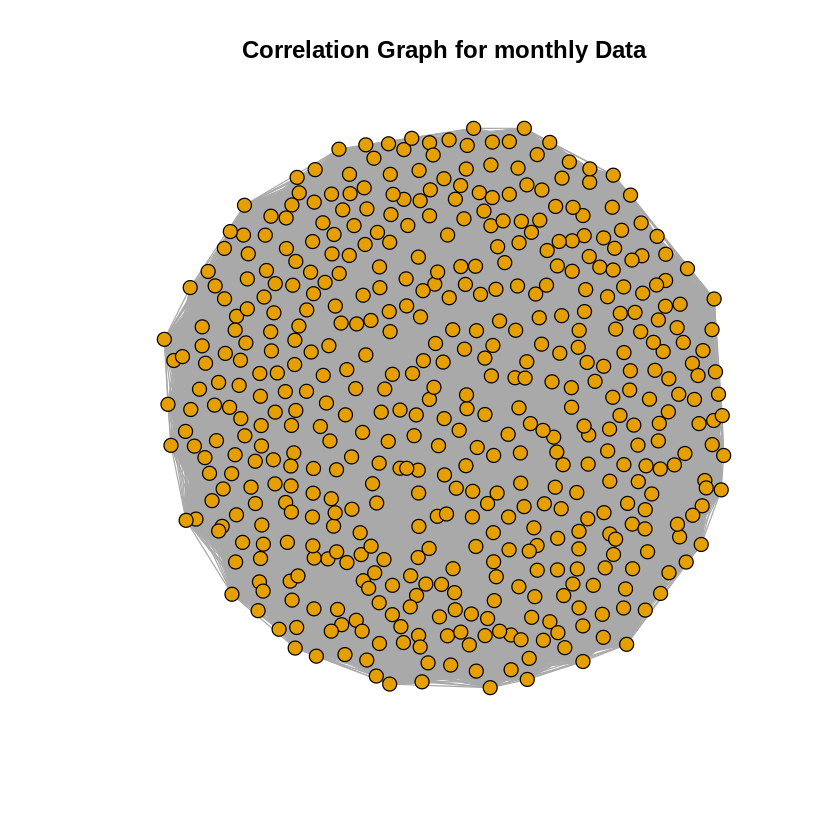

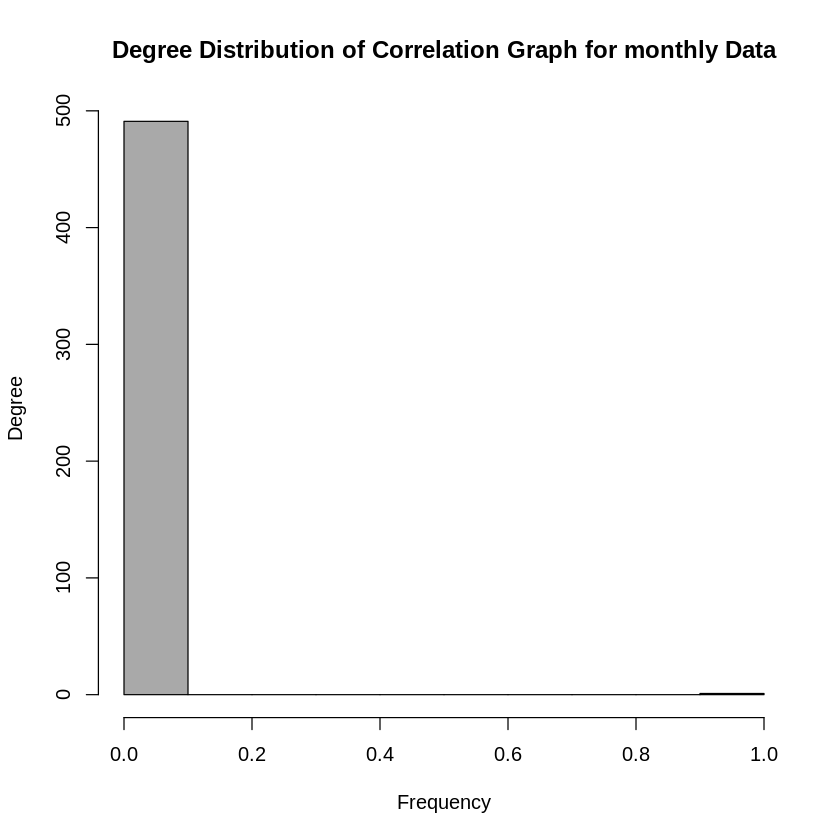

[1] "Number of unique sectors: 11"


[1] "Health Care"                "Industrials"               
 [3] "Consumer Discretionary"     "Information Technology"    
 [5] "Consumer Staples"           "Utilities"                 
 [7] "Financials"                 "Real Estate"               
 [9] "Materials"                  "Energy"                    
[11] "Telecommunication Services"

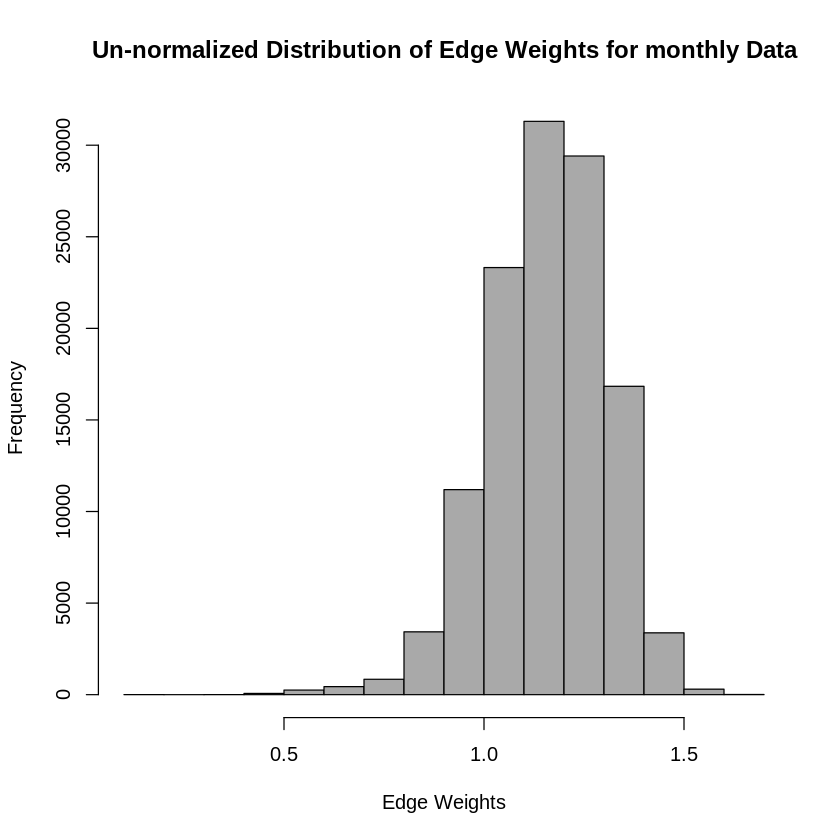

In [ ]:
edge_list_month = read.delim("finance_data/edge_weights_month.txt",header=TRUE)
corr_graph_month = graph.data.frame(edge_list_month, directed = FALSE)
E(corr_graph_month)$weight = edge_list_month[,"Weight"]


# step 4: plot histogram and other data analyis outputs. 
head(edge_list_month,n = 15L)
plot(corr_graph_month, vertex.label="", vertex.size=5,main="Correlation Graph for monthly Data")
hist(degree.distribution(corr_graph_month),col="darkgrey",main="Degree Distribution of Correlation Graph for monthly Data", ylab="Degree",xlab="Frequency")
hist(edge_list_month[,"Weight"],col="darkgrey",main="Un-normalized Distribution of Edge Weights for monthly Data",xlab="Edge Weights",ylab="Frequency")


# Find the number of sectors. 

comp_sectors_month = unique(company_ticker_list_month[,2])
#comp_sectors_month.index<-as.numeric(comp_sectors_month.set)
print(sprintf("Number of unique sectors: %s" , length(comp_sectors_month)))
sprintf(comp_sectors_month)



png 
  2

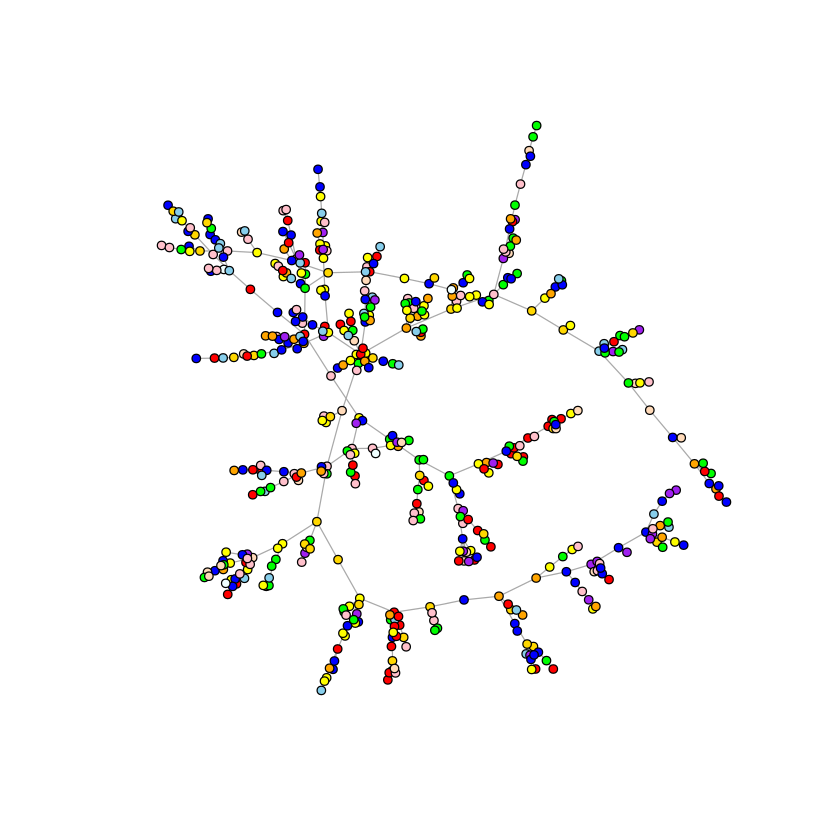

In [ ]:
mst_month <- mst(corr_graph_month,algorithm="prim")
sectors = unique(tickers_sectors[,2])

colors <- c()
  for(v in c(1:vcount(corr_graph_month))){
    cur_sector <- tickers_sectors[v,2]
    i <- which(sectors==cur_sector)
    colors[v] <- switch(i,"red","green","blue","yellow","orange","purple","pink","gold","peachpuff","skyblue","azure")
}

plot(mst_month,vertex.size=3, vertex.label=NA, vertex.color=colors)
dev.copy2eps(file='Q7.eps')


In [ ]:
# Find the value of S_i for all i: The number of memebver in each community. 
S_i = c()
print("Number of nodes belonging each Sector")
for(i in c(1:length(sectors))){
    S_i[i] = length(which(tickers_sectors[,2]==sectors[i]))
    print(sprintf("%s: %s", sectors[i], S_i[i]))
}

# find alpha for 
p_method_1 = c()
p_method_2 = c()
for(v in c(1:vcount(mst_month))){
    neighbors_v = neighbors(mst_month,v)
    N_i = length(neighbors_v)
    Q_i=0
    for(i in neighbors_v){
        if(tickers_sectors[i,2]==tickers_sectors[v,2])
            Q_i=Q_i+1
    }
    p_method_1[v] = Q_i/N_i
    p_method_2[v] = S_i[which(sectors==tickers_sectors[v,2])]/vcount(mst_month)
}

[1] "Number of nodes belonging each Sector"
[1] "Health Care: 60"
[1] "Industrials: 64"
[1] "Consumer Discretionary: 84"
[1] "Information Technology: 66"
[1] "Consumer Staples: 36"
[1] "Utilities: 28"
[1] "Financials: 63"
[1] "Real Estate: 31"
[1] "Materials: 24"
[1] "Energy: 34"
[1] "Telecommunication Services: 4"


In [ ]:
alpha_1 = sum(p_method_1)/vcount(mst_month)
print(sprintf("Alpha value for method 1 is: %s",alpha_1))
alpha_2 = sum(p_method_2)/vcount(mst_month)
print(sprintf("Alpha value for method 2 is: %s",alpha_2))

[1] "Alpha value for method 1 is: 0.511868466898955"
[1] "Alpha value for method 2 is: 0.114610185736004"


In [ ]:
weights_month <- cluster_walktrap(mst_month)

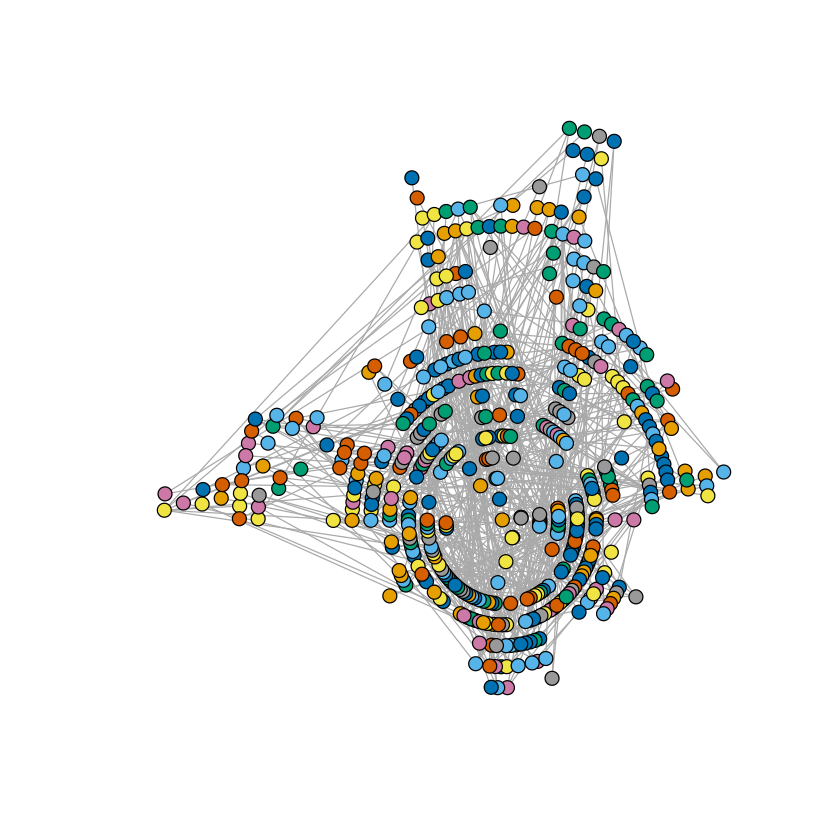

In [ ]:
plot(mst_month,vertex.size=5, vertex.label=NA, vertex.color = weights_month$membership, layout=layout.reingold.tilford(mst,circular=T))

In [ ]:
true<- c(sectors.index)
pred <- c(weights_month$membership)
print("The homogenety for Daily data:\n")
homogeneity(true, pred)
print("The completness for Daily data:\n")
completeness(true,pred)

[1] "The homogenety for Daily data:\n"


[1] 0.4663009

[1] "The completness for Daily data:\n"


[1] 0.3131218